# Advanced Modal Analysis (POD + Mode Selection + DMD + SPOD)

This notebook extends the main POD notebook with deeper methods used in modern data-driven fluid analysis.

Objectives:

- provide mathematical background for each method,
- explain interpretation of outputs,
- demonstrate clean, reusable API usage (all logic in `src/pod_analysis`).


## 1. Problem setup and notation

We work with a snapshot matrix:
$$X \in \mathbb{R}^{n_t \times n_x}$$
where each row is one time snapshot and each column is one spatial degree of freedom.

For dynamics-oriented methods, we also define time-shifted matrices:
$$X_0 = X_{0:n_t-2,:}, \quad X_1 = X_{1:n_t-1,:}$$

These are the core objects used by DMD and related operators.


## 2. POD refresher (context for advanced methods)

After mean-centering $\tilde{X} = X - \bar{X}$, POD uses compact SVD:
$$\tilde{X} = U\Sigma V^T$$

- spatial modes: $\Phi = V$
- temporal coefficients: $A = U\Sigma$
- mode energy fractions: $E_i = \sigma_i^2 / \sum_j \sigma_j^2$

Rank-$r$ reconstruction:
$$X_r = A_r \Phi_r^T + \bar{X}$$

POD is **energy-optimal** for fixed rank (Eckart-Young theorem), but does not explicitly model temporal dynamics.


## 3. Mode selection mathematics and interpretation

Choosing rank $r$ is a model-selection problem, not just a plotting exercise.

Implemented strategies include:

1. **Energy threshold**: choose smallest $r$ with cumulative energy above target.
2. **Elbow criterion**: find curvature change in singular-value decay.
3. **AIC/BIC**: penalize model complexity against residual fit.
4. **Parallel analysis**: keep components stronger than randomized baselines.
5. **Cross-validation** (available in module): choose $r$ by held-out reconstruction quality.

Interpretation rule:
- tight agreement across methods implies robust rank;
- large spread implies uncertainty and requires task-based validation (prediction/control goal).


In [5]:
import sys
from pathlib import Path

ROOT = Path.cwd()
SRC = ROOT / 'src'
if SRC.exists() and str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))

from pod_analysis import (
    AdvancedModalDemo,
    ModeSelectionDemoConfig,
    DMDDemoConfig,
    SPODDemoConfig,
    format_mode_selection_result,
    format_dmd_result,
    format_spod_result,
    plot_spod_spectrum,
)

demo = AdvancedModalDemo()
print(f'Project root: {ROOT}')
print(f'Source path available: {SRC.exists()}')


Project root: /Users/rezami/PycharmProjects/PythonProject5
Source path available: True


## 4. Mode selection demo

Synthetic low-rank data is used so we can inspect how each criterion behaves under controlled signal + noise.


In [6]:
mode_result = demo.run_mode_selection(ModeSelectionDemoConfig())
for line in format_mode_selection_result(mode_result):
    print(line)


Consensus:
{'weighted_mean': 5.4, 'recommended': 5, 'median': 5, 'std': 2.4166091947189146, 'min': 3, 'max': 10, 'all_selections': [3, 5, 10, 4, 5]}
Per-method selected modes:
  energy_95: 3
  energy_99: 5
  elbow: 10
  optimal_threshold: 4
  parallel_analysis: 5


## 5. DMD mathematics and interpretation

DMD approximates linear evolution between snapshots:
$$X_1 \approx A X_0$$

With rank-$r$ truncation of $X_0 = U_r\Sigma_rV_r^T$, reduced operator:
$$\tilde{A} = U_r^T X_1 V_r \Sigma_r^{-1}$$

Solve eigenproblem:
$$\tilde{A}W = W\Lambda$$

Exact DMD modes:
$$\Phi = X_1 V_r \Sigma_r^{-1} W$$

Continuous-time rates (with time step $\Delta t$):
$$\omega_i = \frac{\log(\lambda_i)}{\Delta t} = \alpha_i + i 2\pi f_i$$

Interpretation:
- $f_i$: oscillation frequency
- $\alpha_i$: growth/decay rate
- $|\lambda_i|\le 1$: discrete-time stability

Complex-conjugate pairs correspond to oscillatory structures.


In [7]:
dmd_result = demo.run_dmd(DMDDemoConfig())
for line in format_dmd_result(dmd_result):
    print(line)


True frequencies (Hz): (2.0, 5.0)
Top DMD modes by amplitude:
  Mode 1: f=2.000 Hz, growth=0.0007, amp=4.888
  Mode 2: f=2.000 Hz, growth=0.0007, amp=4.888
  Mode 3: f=5.000 Hz, growth=-0.0020, amp=2.937
  Mode 4: f=5.000 Hz, growth=-0.0020, amp=2.937
  Mode 5: f=22.332 Hz, growth=-264.5500, amp=0.038
  Mode 6: f=22.332 Hz, growth=-264.5500, amp=0.038
Stability summary:
{'n_stable_modes': 8, 'n_unstable_modes': 2, 'max_eigenvalue_magnitude': 1.0000071131903459, 'spectral_radius': 1.0000071131903459, 'dominant_frequency': 1.999997543117554, 'dominant_growth_rate': 0.0007113165047176878}
DMD reconstruction RMSE: 0.008477
BOP-DMD robust modes found: 0


## 6. SPOD mathematics and interpretation

SPOD performs modal decomposition in frequency space.

Given blockwise Fourier coefficients $q_k^{(b)}$ at frequency bin $k$ and block index $b$,
the cross-spectral density (CSD) estimate is:
$$S_k = \frac{1}{B} \sum_{b=1}^{B} q_k^{(b)} (q_k^{(b)})^*$$

SPOD modes solve frequency-wise eigenproblems:
$$S_k \psi_{k,j} = \lambda_{k,j} \psi_{k,j}$$

Interpretation:
- $\lambda_{k,j}$: spectral energy of mode $j$ at frequency $k$
- $\psi_{k,j}$: coherent structure at that frequency

Unlike standard POD, SPOD separates structures by frequency rather than mixing all frequencies into one global basis.


True frequencies (Hz): (20.0, 50.0, 100.0)
Top SPOD peaks:
  f=19.53 Hz, total_energy=0.0261, lead_mode=100.0%
  f=50.78 Hz, total_energy=0.0124, lead_mode=100.0%
  f=101.56 Hz, total_energy=0.0034, lead_mode=99.8%
  f=0.00 Hz, total_energy=0.0000, lead_mode=50.6%
  f=89.84 Hz, total_energy=0.0000, lead_mode=34.5%


/var/folders/yx/bj874jc95xv11n436rkbq2140000gp/T/ipykernel_49904/4224005723.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


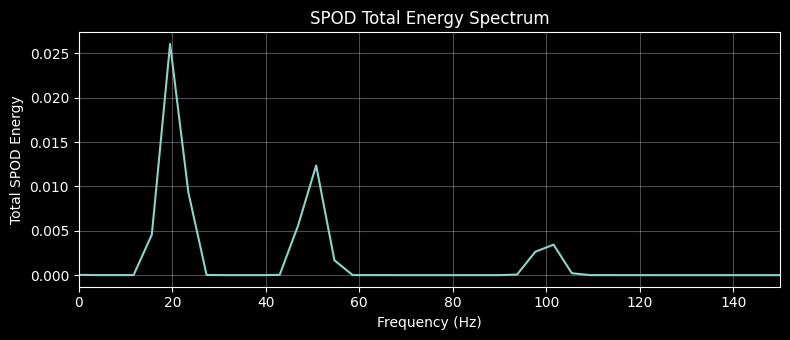

In [8]:
spod_result = demo.run_spod(SPODDemoConfig())
for line in format_spod_result(spod_result):
    print(line)

fig = plot_spod_spectrum(spod_result, max_frequency=150.0)
fig.show()


## 7. How to interpret outputs in practice

### Mode selection
- Use consensus as a starting point.
- If spread is large, carry multiple candidate ranks into downstream validation.

### DMD
- Look for stable conjugate frequency pairs near expected physics.
- Large negative growth rates can indicate fast-decaying transients/noise modes.
- For forecasting, unstable modes require careful handling (clipping/filtering/horizon limits).

### SPOD
- Peak frequencies identify energetic coherent dynamics.
- Leading-mode fraction near 1.0 at a peak indicates strong single-structure dominance.
- Use SPOD when frequency localization matters (e.g., turbulent broadband data).


## 8. Quality notes and limitations

- Current implementation is robust for analysis workflows and tested across POD/DMD/SPOD modules.
- `DMD.predict` may overflow for long horizons when unstable modes exist; this is expected numerically and should be mitigated in production forecasting.

## References
- Schmid (2010), Dynamic Mode Decomposition
- Kutz et al. (2016), Dynamic Mode Decomposition
- Towne, Schmidt & Colonius (2018), SPOD
- Gavish & Donoho (2014), Optimal singular value thresholding
